In [ ]:
!pip install scipy
!pip install vectorbt
!pip install yfinance

Enter the ticker name (Yahoo Finance): PETR3.SA
Enter the ticker name (Yahoo Finance): PETR4.SA

Assets Cointegrated!
Stats t = -4.6815
Confidence level = 99.99957
Half life = 2.15 dias. 

Ratio = 79 shares of PETR3 
 	per 100 shares of PETR4


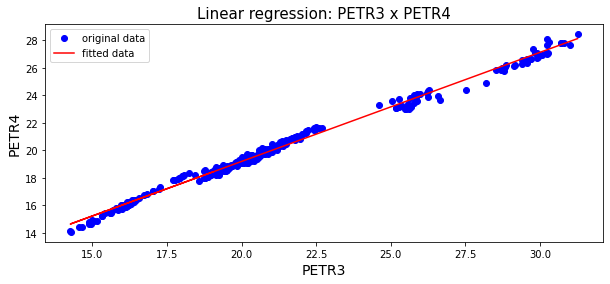

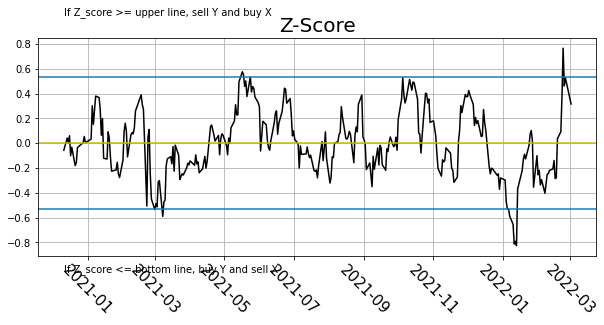

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vectorbt as vbt
import scipy.stats as stats
import os


def download_data(tickers, startDate, endDate, interval):
    data = vbt.YFData.download(symbols=tickers, start=startDate, end=endDate, interval=interval).get('Close')
    return data


def create_csv(data, file_name):
    data.to_csv(file_name)
    # if datetime.now() > data.index[0]:

def get_data(tickers, startDate, endDate, interval):
    file_name = f"{tickers[0]}_{tickers[1]}.csv"
    file_exists = os.path.exists(file_name)
    if file_exists:
        return pd.read_csv(file_name, index_col='Date')
    else:
        create_csv(download_data(tickers, startDate, endDate, interval), file_name)
        return pd.read_csv(file_name, index_col='Date')


def plot_reglin(x, y):
    plt.figure(figsize=(10,4))
    plt.plot(x.iloc[:, 0], x.iloc[:, 1],'ob', label='original data') 
    plt.plot(x.iloc[:, 0], y, '-r', label='fitted data')
    plt.legend()
    plt.title('Linear regression: %s x %s' % (x.columns[0], x.columns[1]), fontsize=15)
    plt.xlabel('{}'.format(x.columns[0]), size=14)
    plt.ylabel('{}'.format(x.columns[1]), size=14)


def z_score(resid):
    return resid - (resid.mean()/resid.std())


def delta_resid(z_score):
    return z_score - z_score.shift(1)


def stats_t(slope, stderror, cut_off):  ## STATS_T NEED TO BE MORE THAN (- 3.44) TO BE COINTEGRATED FOR SAMPLE SIZE > 100
    t = slope/stderror
    if t <= cut_off:  
        print('\nAssets Cointegrated!')
    else:
        print('\nxAssets Not cointegrated!')
    print(f'Stats t = {round(t,5)}')
    return t


def plot_zscore(z):
    plt.figure(figsize=(10,4))
    plt.plot(z, '-k')
    plt.axhline(y= z.mean(), color='y')
    plt.axhline(y=z.mean() + (z.std()*2))
    plt.axhline(y=z.mean() - (z.std()*2))
    plt.xticks(rotation = -45, fontsize=15)
    plt.title('Z-Score', fontsize=20)
    plt.text(z.index[0], (z.mean() + (z.std()*2)+0.5), 'If Z_score >= upper line, sell Y and buy X')
    plt.text(z.index[0], (z.mean() - (z.std()*2)-0.5), 'If Z_score <= bottom line, buy Y and sell X')
    plt.grid()

    

def half_life(z, reg_resid):
    half = round(-np.log10(2)/reg_resid.slope, 2) ## Half life formula
    print('Half life =',half, 'dias. \n')
    

def size_position(data, result):
    print(f'Ratio = {result*100:.0f} shares of', f'{data.columns[0]}', f'\n \tper 100 shares of {data.columns[1]}')
    # print('\n multiply the ratio with the number of shares you want to trade')



def main ():
    start_date = '2020-01-01 UTC'
    end_date = '2022-03-03 UTC'
    interval = '1D'
    tickers = [str(input('Enter the ticker name (Yahoo Finance): ')) for i in range(1,3)]
    df = get_data(tickers, start_date, end_date, interval)
    df.index = pd.to_datetime(df.index)
    df.columns = [x.strip('.SA') for x in df.columns]  ## STRIP '.SA' FROM BRAZILIAN COMPANIES 


    ### MAKE THE COINTEGRATION WITH YOUR NUMBER OF DAYS ### 
    time_period = 300
    X_independent = df.iloc[-time_period:,0]
    Y_dependent = df.iloc[-time_period:,1]


    result = stats.linregress(X_independent, Y_dependent)
    y_pred = result.intercept + result.slope * X_independent
    residual = Y_dependent - y_pred


    ## PLOT DATA AND REGRESSION ## 
    plot_reglin(df[-time_period:], y_pred)


    z = z_score(residual)
    delta_res = delta_resid(z)
    result2 = stats.linregress(x = z[:-1], y = delta_res[1:]) 

    cut_off = -3.43
    stats_t(result2.slope, result2.stderr, cut_off)
    print('Confidence level =',(round(100 * (1 - result2.pvalue), 5))) 
    half_life(z, result2)
    plot_zscore(z)

    size_position(df, result.slope)




if __name__ == '__main__':
    main()